# Washington DC Biking data | Hourly Bike Count Prediction


Rafael Hernandez - MDB - Term 3 - Advanced Python

# Executive Summary

The report details steps taken to predict number of total bikers on hourly basis for the last quarter of 2012 for Washington D.C. bike sharing system. The dataset comprises of hourly data and daily data from 2011 to 2012, daily data is merely an aggregation of hourly data. For the purpose of analysis, only hourly data was used. Two-step approach was followed to compute predictions, first, level 0 models were used to predict for third quarter of 2012 and then stacked ensemble was used to predict for fourth quarter of 2012. Linear forest, XGBoost, Random forest regressor, and K nearest neighbor were used to compute Level 0 predictions, which were added to explanatory data. Further, XGBoost was trained on quarter 3 explanatory variables, which contained predictions of level 0 models, to predict for the test set. The final accuracy score is 0.897. As the model is able to predict number of bike users with almost 90% accuracy, it can be used by Washington D.C. bike sharing system to forecast demand and manage inventory levels.

# 1. EDA + Baseline

### Notebook preperation

In [54]:
# To automatically reload the function file 
%load_ext autoreload
%aimport My_Functions
%run My_Functions.py
%autoreload 1
%matplotlib inline
warnings.simplefilter(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Data Import with Dask Dataframe
hourly_raw_data = dd.read_csv('gs://bikeshareproject/hour.csv')

# Data Import with Panda
hourly_raw_data_pd = pd.read_csv('hour.csv')

_call out of retries on exception: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/service-accounts/default/?recursive=true (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1c27172588>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
Traceback (most recent call last):
  File "/Users/rafaelhernandez/miniconda3/envs/intro_python/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/Users/rafaelhernandez/miniconda3/envs/intro_python/lib/python3.7/site-packages/urllib3/util/connection.py", line 57, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/Users/rafaelhernandez/miniconda3/envs/intro_python/lib/python3.7/socket.py", line 748, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family

In [47]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:49317 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [4]:
%time len(hourly_raw_data)

CPU times: user 70.8 ms, sys: 23.4 ms, total: 94.2 ms
Wall time: 1.19 s


17379

In [5]:
%time len(hourly_raw_data_pd)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 17.2 µs


17379

# EDA

Data understanding is the key component of carrying out a prediction task. Therefore, naturally, interactive and statics plots are utilized to understand the dataset. Dataset is divided into two files, hourly data and daily data, the latter is merely an aggregation of hourly data. Hence, exploratory data analysis was carried out using hourly data. 

In [6]:
# Making a copy of hourly data for graphs
graph_data_hourly=hourly_raw_data.copy()
#graph_data_hourly["dteday"]=graph_data_hourly["dteday"].map(lambda x:  pd.to_datetime(x))
graph_data_hourly["dteday"]= dd.to_datetime(graph_data_hourly.dteday ,unit='ns')

In [7]:
graph_data_hourly = graph_data_hourly.compute()

Interactive time series plot shows that there are seasonal variations in data. Number of total bikers increase Despite seasonal variations, there is a positive year-on- year trend in the number of total bikers.

In [8]:
mpl_fig = plt.figure()
ax= plt.axes()
ax.plot(graph_data_hourly['dteday'],graph_data_hourly['cnt'])
ax.plot(graph_data_hourly['dteday'],graph_data_hourly['registered'])
ax.plot(graph_data_hourly['dteday'],graph_data_hourly['casual'])
#ax.legend(['cnt', 'registered', 'casual'], loc='upper left')
#ax.figure(figsize=(20,10))
# locator=MaxNLocator(prune='both',nbins=8)
# ax.xaxis.set_major_locator(locator)


plotly_fig=tls.mpl_to_plotly(mpl_fig)
plotly_fig['layout']['xaxis'] = {
   'tickmode': 'auto',
   'nticks': 10
    }
plotly_fig['layout']['showlegend'] = True
plotly_fig['layout'] = {'width':800}
plotly_fig['layout']['title'] = 'Hourly Bike Users'
py.iplot(plotly_fig,filename='Hourly_Bike_Users')

The draw time for this plot will be slow for clients without much RAM.


The distributions of casual, registered, and total bikers show outliers. This finding proves that in the span of dataset, there were times when number of bikers were much greater than the overall trend. In order to enable the model to capture unexpected increase in bikers, multiple features are created, which will be detailed in the feature engineering part.

The boxplots for seasonal variables, namely, temp, atemp, hum and wind speed, show outliers for hum and wind speed. This finding, also, fed into feature creation for seasonal variables in order for the model to be powerful enough to capture such outliers.

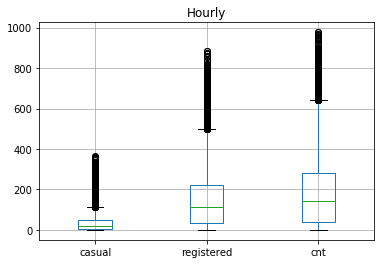

In [9]:
graph_data_hourly.boxplot(column = ['casual','registered','cnt'])
plt.title('Hourly')
plt.show()

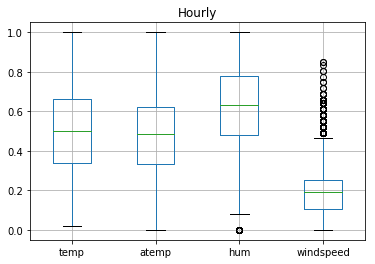

In [10]:
graph_data_hourly.boxplot(column = ['temp','atemp','hum','windspeed'])
plt.title('Hourly')
plt.show()

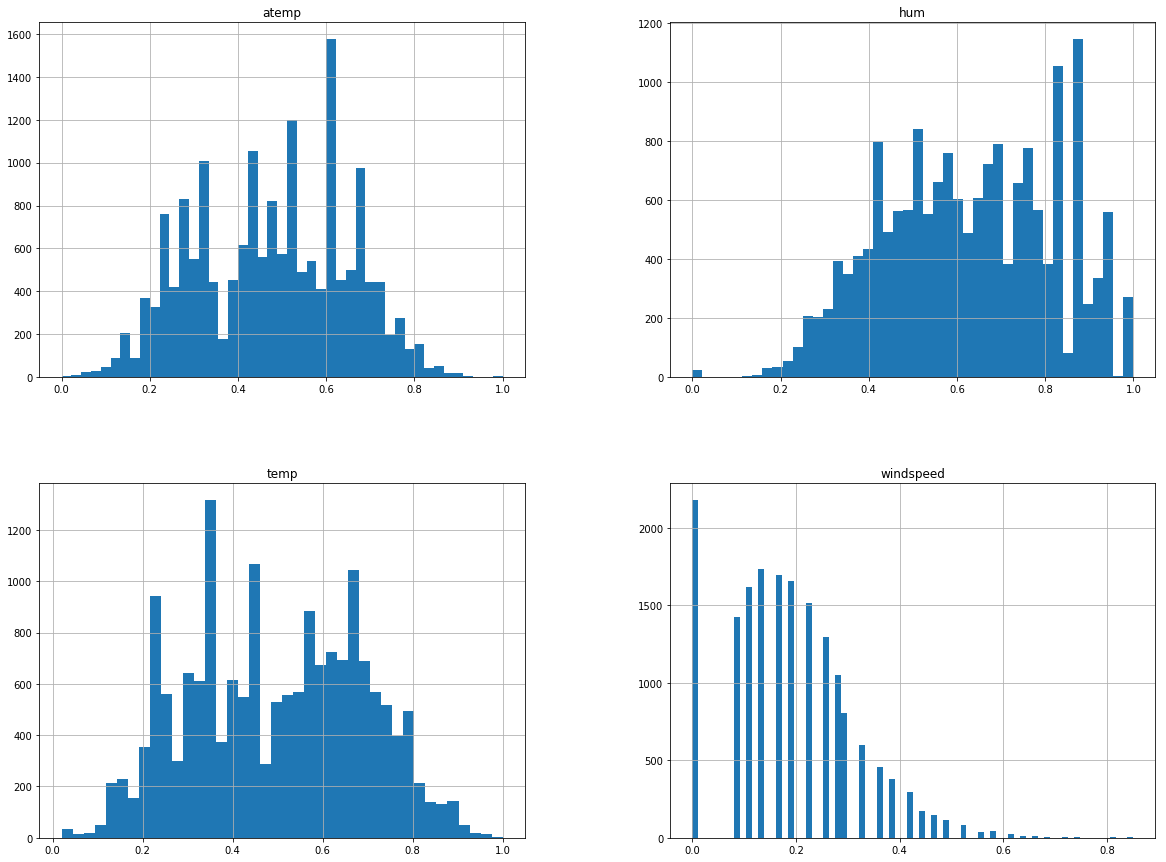

In [11]:
num_bins = 'auto'
to_hist = ['atemp','temp','hum','windspeed']
graph_data_hourly[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

The line charts show that number of total bikers are highly affected by weather. The seasonal variations for number of total bikers and weather follow an identical trend. Therefore, it is reasonable to expect that weather will play an important part in predicting number of total bikers. 

Text(0.5, 1.0, 'Humidity per Hour')

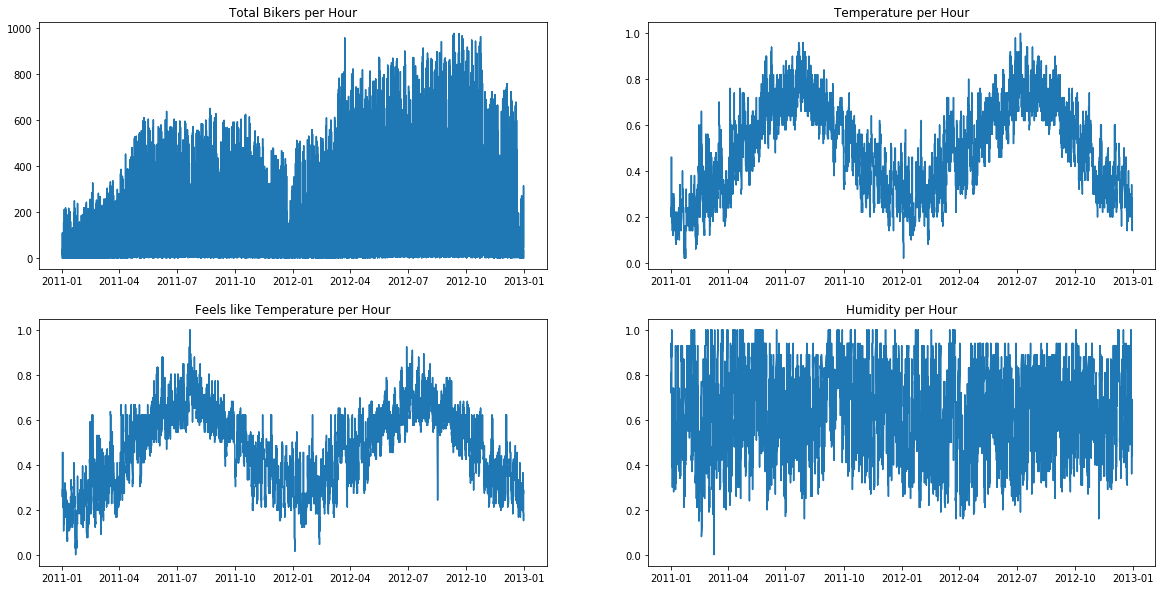

In [12]:
plt.figure(figsize=(20,10))
plt.subplot(2,2, 1)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['cnt'])
plt.title('Total Bikers per Hour')
plt.subplot(2, 2, 2)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['temp'])
plt.title('Temperature per Hour')
plt.subplot(2, 2, 3)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['atemp'])
plt.title('Feels like Temperature per Hour')
plt.subplot(2, 2, 4)
plt.plot(graph_data_hourly['dteday'],graph_data_hourly['hum'])
plt.title('Humidity per Hour')

Another important finding is that the total bikers are much higher on weekends compared to weekdays. The difference in number of total bikers on weekends vs. working days justifies that the data should be split and modeled separately. However, graph for total bikers on working days vs. holidays is a proof that number of total bikers do not only increase on weekends, but also on holidays that are during the weekdays. Therefore, data is split between working days and holidays. Predictions for the two datasets are computed separately. 

[Text(0.5, 1.0, 'Weekday wise hourly distribution of Total Bikers')]

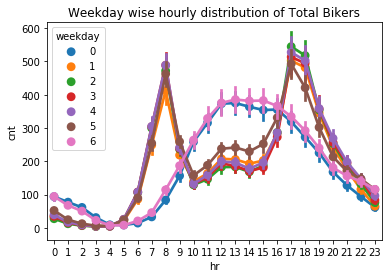

In [13]:
# Option 1 for weekend/weekday graph
fig,ax = plt.subplots()
sns.pointplot(data=graph_data_hourly[['hr',
                           'cnt',
                           'weekday']],
              x='hr',
              y='cnt',
              hue='weekday',
              ax=ax)
ax.set(title="Weekday wise hourly distribution of Total Bikers")

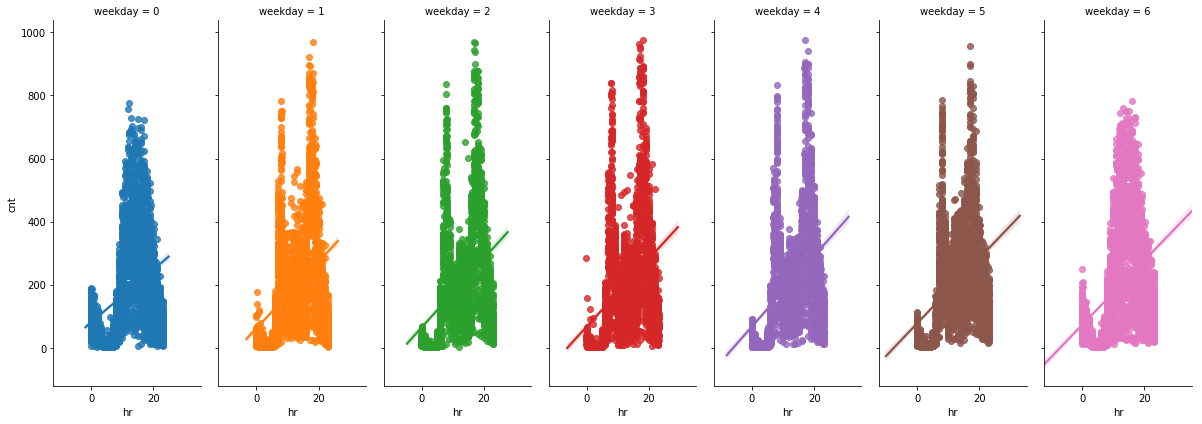

In [14]:
# option 2 for weekend/weekday graphs
g = sns.lmplot(x="hr", y="cnt", hue="weekday", col="weekday",data=graph_data_hourly, height=6, aspect=.4, x_jitter=.1)

[Text(0.5, 1.0, 'Weekday wise hourly distribution of Total Bikers')]

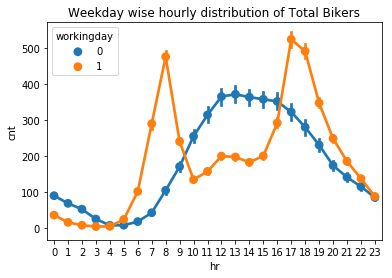

In [15]:
# workingday/holiday graph
fig,ax = plt.subplots()
sns.pointplot(data=graph_data_hourly[['hr',
                           'cnt',
                           'workingday']],
              x='hr',
              y='cnt',
              hue='workingday',
              ax=ax)
ax.set(title="Weekday wise hourly distribution of Total Bikers")

### EDA after splitting (Working Data / Holiday Days)

In [16]:
workingdays = num_name(hourly_raw_data.loc[(hourly_raw_data['workingday'].isin([1]) )]).compute()
holidays = num_name(hourly_raw_data.loc[(~hourly_raw_data['workingday'].isin([1]) )]).compute()

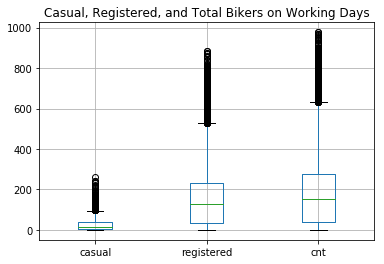

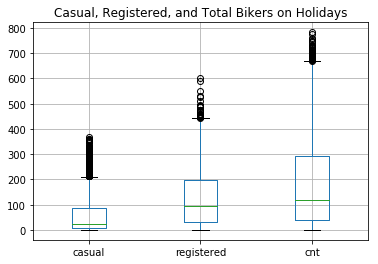

In [17]:
workingdays.boxplot(column = ['casual','registered','cnt'])
plt.title('Casual, Registered, and Total Bikers on Working Days')
plt.show()
holidays.boxplot(column = ['casual','registered','cnt'])
plt.title('Casual, Registered, and Total Bikers on Holidays')
plt.show()

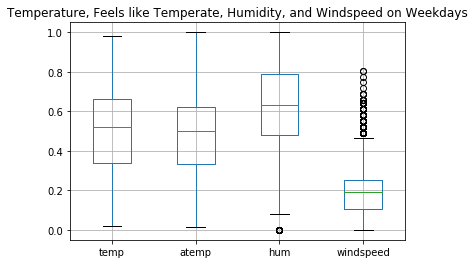

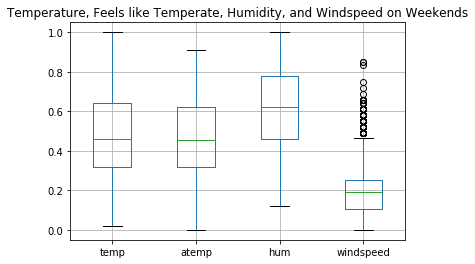

In [18]:
workingdays.boxplot(column = ['temp','atemp','hum','windspeed'])
plt.title('Temperature, Feels like Temperate, Humidity, and Windspeed on Weekdays')
plt.show()
holidays.boxplot(column = ['temp','atemp','hum','windspeed'])
plt.title('Temperature, Feels like Temperate, Humidity, and Windspeed on Weekends')
plt.show()

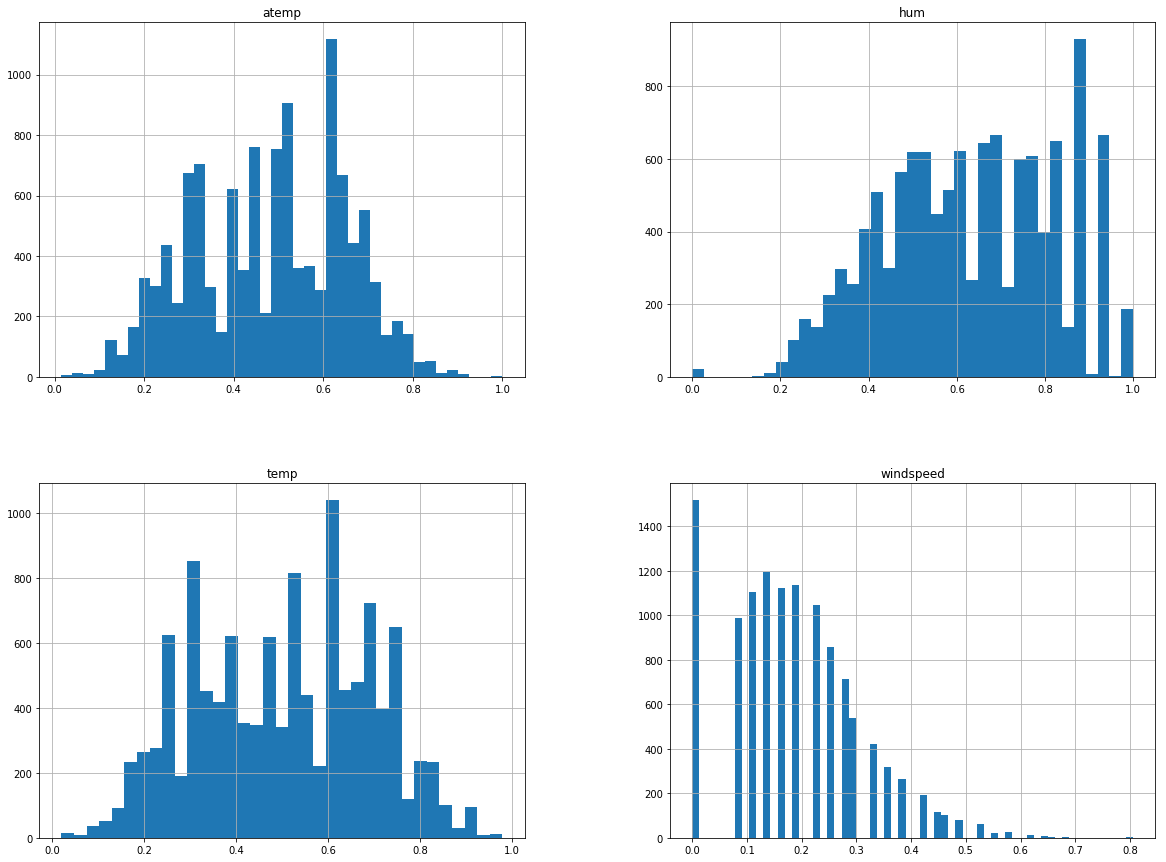

In [19]:
num_bins = 'auto'
to_hist = ['atemp','temp','hum','windspeed']
workingdays[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

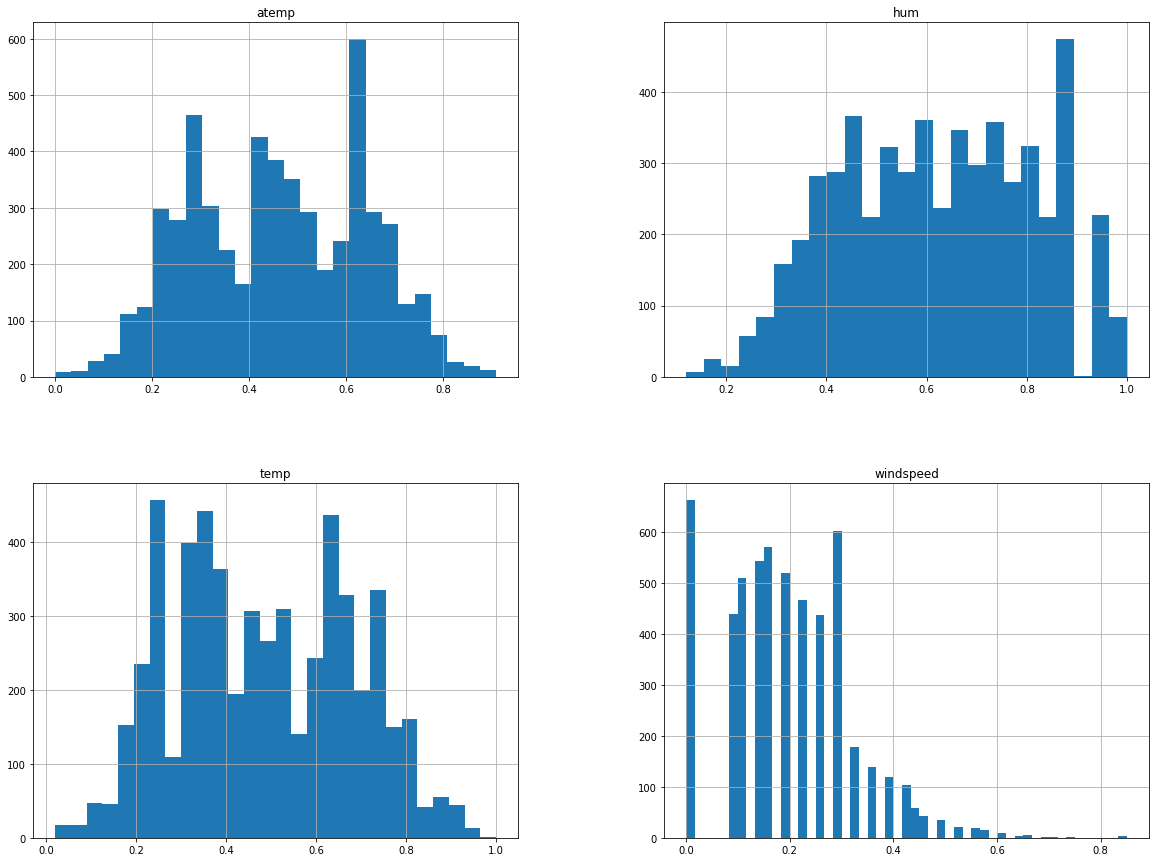

In [20]:
num_bins = 'auto'
to_hist = ['atemp','temp','hum','windspeed']
holidays[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

Text(0.5, 1.0, 'Humidity on Weekend')

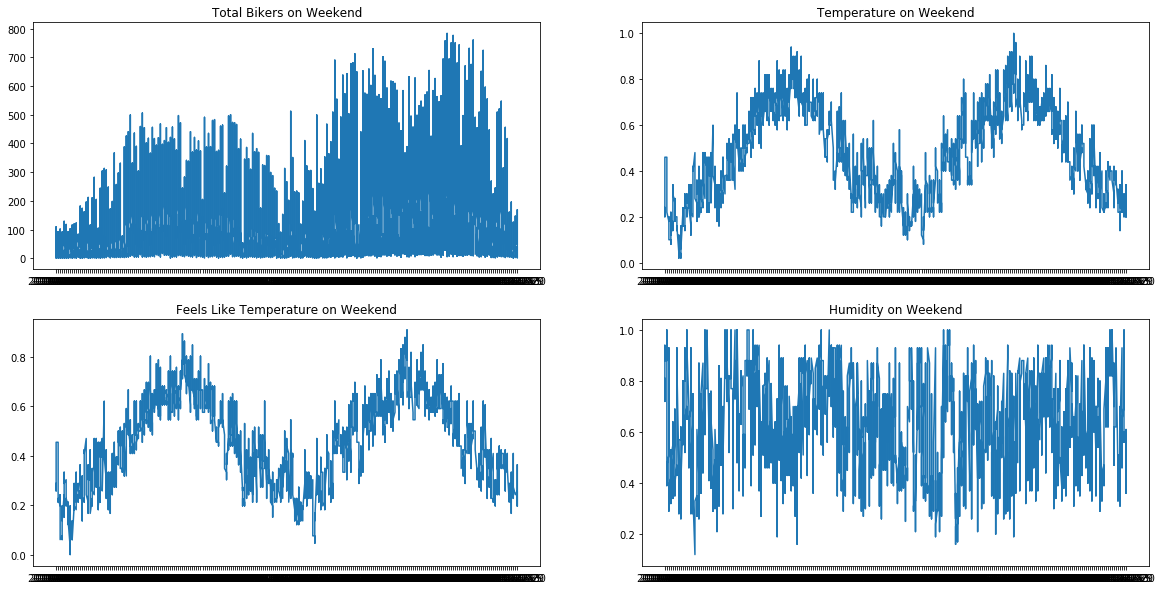

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(2,2, 1)
plt.plot(holidays['dteday'],holidays['cnt'])
plt.title('Total Bikers on Weekend')
plt.subplot(2, 2, 2)
plt.plot(holidays['dteday'],holidays['temp'])
plt.title('Temperature on Weekend')
plt.subplot(2, 2, 3)
plt.plot(holidays['dteday'],holidays['atemp'])
plt.title('Feels Like Temperature on Weekend')
plt.subplot(2, 2, 4)
plt.plot(holidays['dteday'],holidays['hum'])
plt.title('Humidity on Weekend')

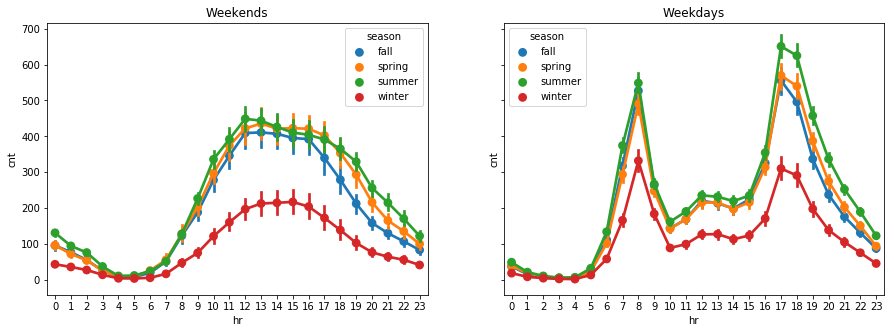

In [22]:
fig,ax = plt.subplots(1,2,sharey=True,sharex=True,figsize=(15,5))
#plt.figure(figsize=(1000,1000))
sns.pointplot(data=holidays[['hr',
                           'cnt',
                           'season']],
              x='hr',
              y='cnt',
              hue='season',
              ax=ax[0])
sns.pointplot(data=workingdays[['hr',
                           'cnt',
                           'season']],
              x='hr',
              y='cnt',
              hue='season',
              ax=ax[1])
ax[0].set(title="Weekends")
ax[1].set(title="Weekdays")
plt.show()
fig.savefig('test2')

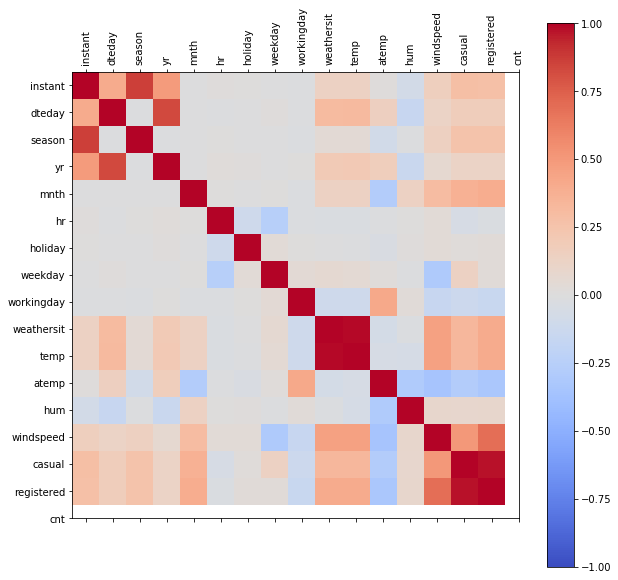

In [23]:
hey = hourly_raw_data.compute().corr()['cnt'][:]
hey.sort_values()

#Hourly
plt.rcParams["figure.figsize"] = (10,10)
corr = hourly_raw_data.compute().corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(hourly_raw_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(hourly_raw_data.columns)
ax.set_yticklabels(hourly_raw_data.columns)
plt.show()

# Modeling (Baseline)

Two data cleaning steps are taken before running a baseline model:

Converting Date to datetime64 format  
One-hot encoding of categorical variables

### Converting `dteday` to date

In [24]:
hourly_raw_data['dteday']=dd.to_datetime(hourly_raw_data['dteday'], format='%Y-%m-%d')
hourly_raw_data['dteday'].head()

0   2011-01-01
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
Name: dteday, dtype: datetime64[ns]

In [28]:
hourly_raw_data.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null datetime64[ns]
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(12)
memory usage: 2.3 MB


### One hot Encoding
For `season`, `weathersit`, `mnth`,`weekday`,`hr`

In [31]:
category  = ['season', 'weathersit', 'mnth','weekday','hr']
pipeline = make_pipeline(Categorizer(columns=category), DummyEncoder(columns=category))
hourly_raw_data = pipeline.fit_transform(hourly_raw_data)

### Final data before Baseline

In [38]:
hourly_raw_data.head()

,instant,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,...,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23
0,1,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,...,0,0,0,0,0,0,0,0,0,0
1,2,2011-01-01,0,0,0,0.22,0.2727,0.80,0.0,8,...,0,0,0,0,0,0,0,0,0,0
2,3,2011-01-01,0,0,0,0.22,0.2727,0.80,0.0,5,...,0,0,0,0,0,0,0,0,0,0
3,4,2011-01-01,0,0,0,0.24,0.2879,0.75,0.0,3,...,0,0,0,0,0,0,0,0,0,0
4,5,2011-01-01,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting train test

The dataset is split into train and test set. The train set comprises of data from the first quarter of 2011 till the end of second quarter of 2012 and the test set comprises of third quarter of 2012. Predictions are made for the third quarter of 2012 in the baseline step. The explanatory variables neither include casual users not registered users. The target variable is total users. 

In [44]:
X_Train_dd = hourly_raw_data[hourly_raw_data['dteday'] < datetime.datetime(2012, 7, 1, 0, 0)].drop(['cnt','casual','registered','dteday'],axis=1)## NONE OF THst_EM IN DATA
y_train_dd =hourly_raw_data['cnt'][hourly_raw_data['dteday'] < datetime.datetime(2012, 7, 1, 0, 0)]

X_Test_dd = hourly_raw_data[(hourly_raw_data['dteday'] >= datetime.datetime(2012, 7, 1, 0, 0)) & (hourly_raw_data['dteday'] <= datetime.datetime(2012, 9, 30, 0, 0))].drop(['cnt','casual','registered','dteday'],axis=1)## NONE OF THEM IN DATA
y_test_dd =hourly_raw_data['cnt'][(hourly_raw_data['dteday'] >= datetime.datetime(2012, 7, 1, 0, 0)) & (hourly_raw_data['dteday'] <= '2012-09-30')]


In [59]:
X_Train = X_Train_dd.values
y_train = y_train_dd.values

X_Test = X_Test_dd
y_test = y_test_dd

### Linear Regression

A simple linear regression is used to predict hourly bikers for the third quarter of 2012. Baseline model predicts the number of total bikers with an accuracy of 60%.

In [60]:
from sklearn.metrics import r2_score

#X_Train, y_train = make_regression()
lr = LinearRegression()
lr.fit(X_Train, y_train)
lr.predict(X_Test)
lr.score(X_Test, y_test) #Error in dask_ml default is MSE and not R2 score
r2_score(X_Test.compute(), y_test.compute())

TypeError: This estimator does not support dask dataframes.

In [25]:
regr = LinearRegression(fit_intercept =True)
regr.fit(X_Train, Y_cnt_train)
y_pred = regr.predict(X_Test)
r2_score(Y_cnt_test,Y_cnt_test + y_pred)
regr.score(X_Test, Y_cnt_test)

NameError: name 'X_Train' is not defined